## Dataset Selection

I use `Abstract Art Gallery` from Kaggle for this project.

Datasets Link: [Abstract Art Gallery](https://www.kaggle.com/bryanb/abstract-art-gallery)



## Understand and describe the modeling objective



*   This is a image dataset. This dataset contains 2782 files of abstract images.
*   I want to use Generative modeling in this dataset.



## Download Dataset

In [2]:
!pip install opendatasets --upgrade --quiet

In [4]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/bryanb/abstract-art-gallery'
od.download(dataset_url)

  1%|          | 5.00M/415M [00:00<00:09, 43.3MB/s]

100%|██████████| 415M/415M [00:03<00:00, 136MB/s]


In [5]:
import os

DATA_DIR = '/content/abstract-art-gallery'
print(os.listdir(DATA_DIR))

['Abstract_gallery']


In [6]:
print(os.listdir(DATA_DIR+'/Abstract_gallery')[:10])

['Abstract_image_1820.jpg', 'Abstract_image_1654.jpg', 'Abstract_image_2109.jpg', 'Abstract_image_2226.jpg', 'Abstract_image_621.jpg', 'Abstract_image_639.jpg', 'Abstract_image_1494.jpg', 'Abstract_image_1642.jpg', 'Abstract_image_2732.jpg', 'Abstract_image_2448.jpg']


In [7]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [8]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [9]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
                                                      T.Resize(image_size),
                                                      T.CenterCrop(image_size),
                                                      T.ToTensor(),
                                                      T.Normalize(*stats)]))
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [10]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [12]:
def show_images(images,nmax=64):
  fig, ax = plt.subplots(figsize=(8,8))
  ax.set_xticks([]); ax.set_xticks([])
  ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1,2,0))

def show_batch(dl, nmax=64):
  for images, _ in dl:
    show_images(images, nmax)
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


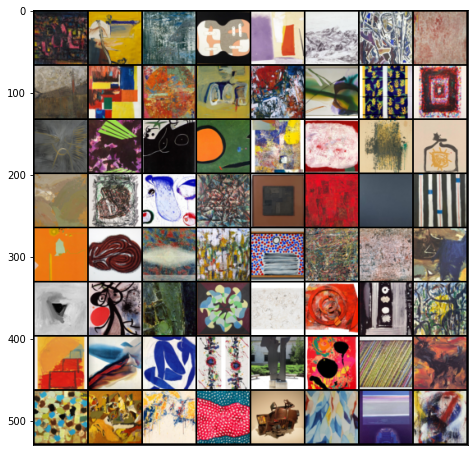

In [13]:
show_batch(train_dl)

In [17]:
project_name = 'zerotogans-project'

In [14]:
!pip install jovian --upgrade --quiet

In [15]:
import jovian

In [18]:
jovian.commit(project=project_name, environment=None)

[jovian] Detected Colab notebook...
[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/anirbansaha/zerotogans-project


'https://jovian.ai/anirbansaha/zerotogans-project'

In [19]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [20]:
device = get_default_device()
device

device(type='cuda')

In [21]:
train_dl = DeviceDataLoader(train_dl, device)

In [22]:
import torch.nn as nn

In [23]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [24]:
discriminator = to_device(discriminator, device)

In [26]:
latent_size = 128

In [27]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


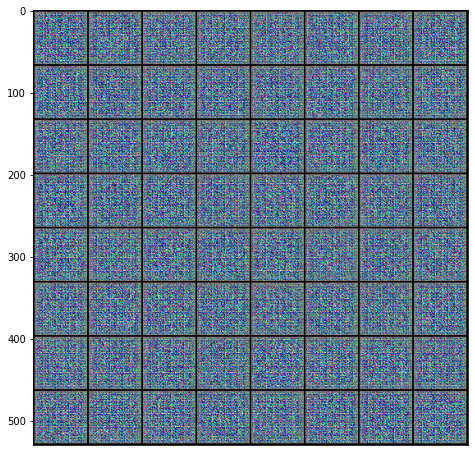

In [28]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [29]:
generator = to_device(generator, device)

In [30]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [31]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [32]:
from torchvision.utils import save_image

In [33]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [34]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [35]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

In [36]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [37]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [38]:
lr = 0.0002
epochs = 25

In [39]:
jovian.reset()
jovian.log_hyperparams(lr=lr, epochs=epochs)

[jovian] Hyperparams logged.


In [40]:
history = fit(epochs, lr)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Epoch [1/25], loss_g: 7.6489, loss_d: 0.4046, real_score: 0.7806, fake_score: 0.1259
Saving generated-images-0001.png



Epoch [2/25], loss_g: 14.6288, loss_d: 2.1275, real_score: 0.9265, fake_score: 0.8662
Saving generated-images-0002.png



Epoch [3/25], loss_g: 4.8344, loss_d: 0.2955, real_score: 0.7973, fake_score: 0.0199
Saving generated-images-0003.png



Epoch [4/25], loss_g: 5.3846, loss_d: 0.5218, real_score: 0.6692, fake_score: 0.0228
Saving generated-images-0004.png



Epoch [5/25], loss_g: 1.5872, loss_d: 1.5929, real_score: 0.4903, fake_score: 0.4091
Saving generated-images-0005.png



Epoch [6/25], loss_g: 4.3617, loss_d: 0.3750, real_score: 0.8184, fake_score: 0.1299
Saving generated-images-0006.png



Epoch [7/25], loss_g: 5.6949, loss_d: 0.5226, real_score: 0.8170, fake_score: 0.2297
Saving generated-images-0007.png



Epoch [8/25], loss_g: 3.0267, loss_d: 0.1028, real_score: 0.9466, fake_score: 0.0445
Saving generated-images-0008.png



Epoch [9/25], loss_g: 4.6221, loss_d: 2.1187, real_score: 0.1933, fake_score: 0.0004
Saving generated-images-0009.png



Epoch [10/25], loss_g: 7.0894, loss_d: 1.1335, real_score: 0.5712, fake_score: 0.0871
Saving generated-images-0010.png



Epoch [11/25], loss_g: 3.7060, loss_d: 0.2388, real_score: 0.9125, fake_score: 0.1025
Saving generated-images-0011.png



Epoch [12/25], loss_g: 4.7295, loss_d: 0.4146, real_score: 0.9742, fake_score: 0.2939
Saving generated-images-0012.png



Epoch [13/25], loss_g: 6.4539, loss_d: 0.3430, real_score: 0.9330, fake_score: 0.2181
Saving generated-images-0013.png



Epoch [14/25], loss_g: 4.7923, loss_d: 0.4392, real_score: 0.8861, fake_score: 0.2414
Saving generated-images-0014.png



Epoch [15/25], loss_g: 3.0443, loss_d: 2.7836, real_score: 0.1406, fake_score: 0.0042
Saving generated-images-0015.png



Epoch [16/25], loss_g: 2.9008, loss_d: 0.7613, real_score: 0.6365, fake_score: 0.1430
Saving generated-images-0016.png



Epoch [17/25], loss_g: 2.0814, loss_d: 0.3374, real_score: 0.8916, fake_score: 0.1832
Saving generated-images-0017.png



Epoch [18/25], loss_g: 4.6147, loss_d: 0.7964, real_score: 0.8907, fake_score: 0.4433
Saving generated-images-0018.png



Epoch [19/25], loss_g: 2.9789, loss_d: 0.6139, real_score: 0.8067, fake_score: 0.3004
Saving generated-images-0019.png



Epoch [20/25], loss_g: 4.0321, loss_d: 0.2401, real_score: 0.9215, fake_score: 0.1367
Saving generated-images-0020.png



Epoch [21/25], loss_g: 5.1819, loss_d: 1.4912, real_score: 0.9496, fake_score: 0.7049
Saving generated-images-0021.png



Epoch [22/25], loss_g: 3.1015, loss_d: 0.3257, real_score: 0.8343, fake_score: 0.0909
Saving generated-images-0022.png



Epoch [23/25], loss_g: 2.2811, loss_d: 0.3837, real_score: 0.7776, fake_score: 0.0872
Saving generated-images-0023.png



Epoch [24/25], loss_g: 5.7185, loss_d: 0.6642, real_score: 0.9451, fake_score: 0.4281
Saving generated-images-0024.png



Epoch [25/25], loss_g: 2.6925, loss_d: 0.2963, real_score: 0.8460, fake_score: 0.1091
Saving generated-images-0025.png


In [41]:
losses_g, losses_d, real_scores, fake_scores = history

In [42]:
jovian.log_metrics(loss_g=losses_g[-1], 
                   loss_d=losses_d[-1], 
                   real_score=real_scores[-1], 
                   fake_score=fake_scores[-1])

[jovian] Metrics logged.


In [43]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [44]:
from IPython.display import Image

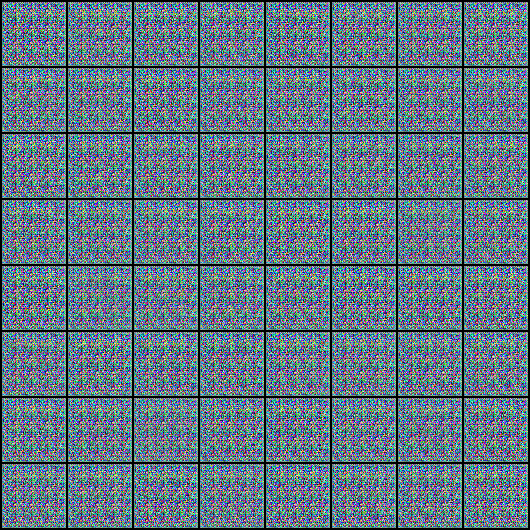

In [45]:
Image('./generated/generated-images-0001.png')

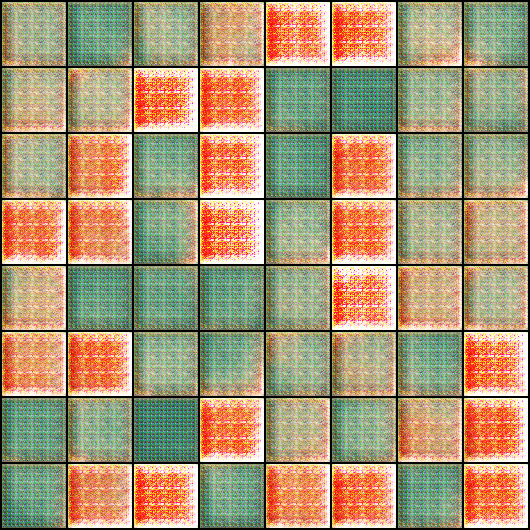

In [46]:
Image('./generated/generated-images-0010.png')

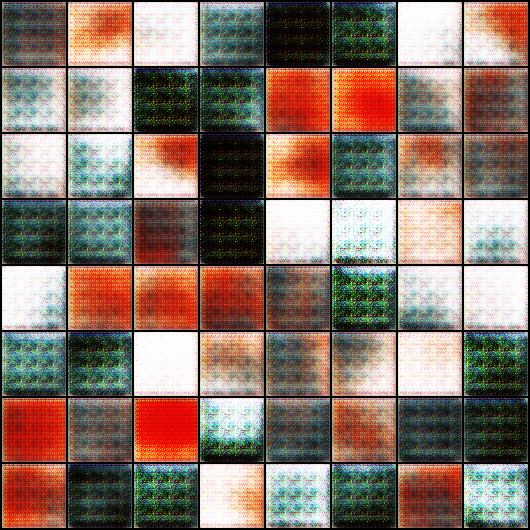

In [47]:
Image('./generated/generated-images-0015.png')

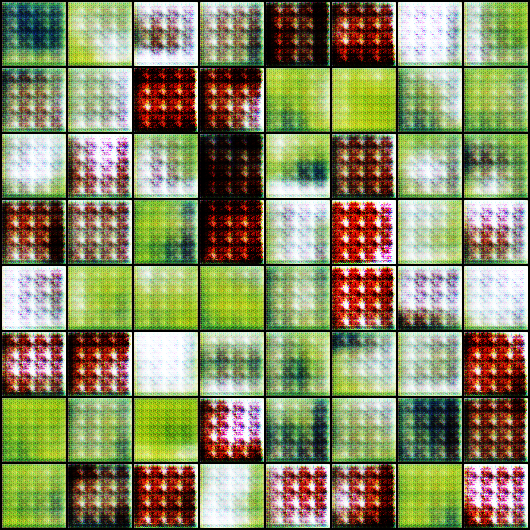

In [48]:
Image('./generated/generated-images-0020.png')

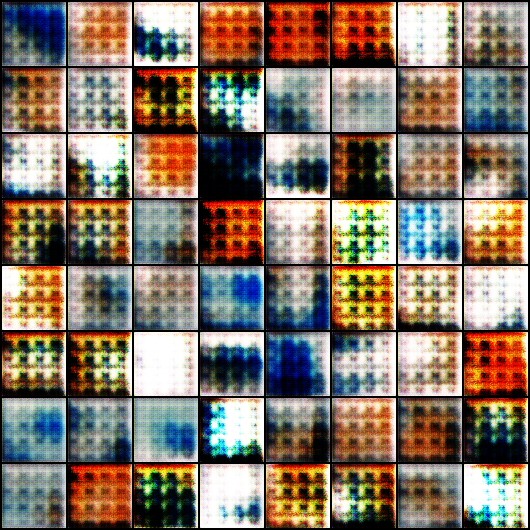

In [49]:
Image('./generated/generated-images-0025.png')

In [50]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

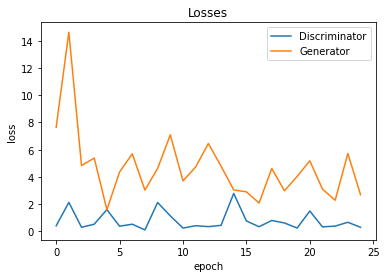

In [51]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

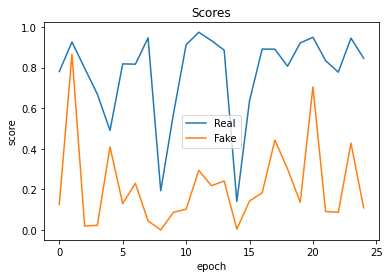

In [52]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

In [53]:
import jovian

In [54]:
jovian.commit(project=project_name, 
              outputs=['G.pth', 'D.pth', 'gans_training.avi'], 
              environment=None)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Uploading additional outputs...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
Committed successfully! https://jovian.ai/anirbansaha/zerotogans-project


'https://jovian.ai/anirbansaha/zerotogans-project'

In [55]:
jovian.submit(assignment="zerotogans-project")

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
Committed successfully! https://jovian.ai/anirbansaha/zerotogans-project
[jovian] Submitting assignment..
[jovian] Verify your submission at https://jovian.ai/learn/deep-learning-with-pytorch-zero-to-gans/assignment/course-project
